![CC](https://i.creativecommons.org/l/by/4.0/88x31.png)

This work is licensed under a [Creative Commons Attribution 4.0 International License](http://creativecommons.org/licenses/by/4.0/).

# Finite-volume-based CFD in a nutshell

- FVM fundamentals  
  - Mathematical problem
  - Domain discretization (meshing)
  - Equation discretization part I - diffusion
  - Iterative solution
  - Equation discretization part II - convection
- FVM in OpenFOAM
- FVM in Basilisk

## FVM fundamentals

### Mathematical problem

In [62]:
from os.path import join
import matplotlib.pyplot as plt
import torch as pt

# increase plot resolution
plt.rcParams["figure.dpi"] = 160

# create output directory
output = "output"
!mkdir -p $output

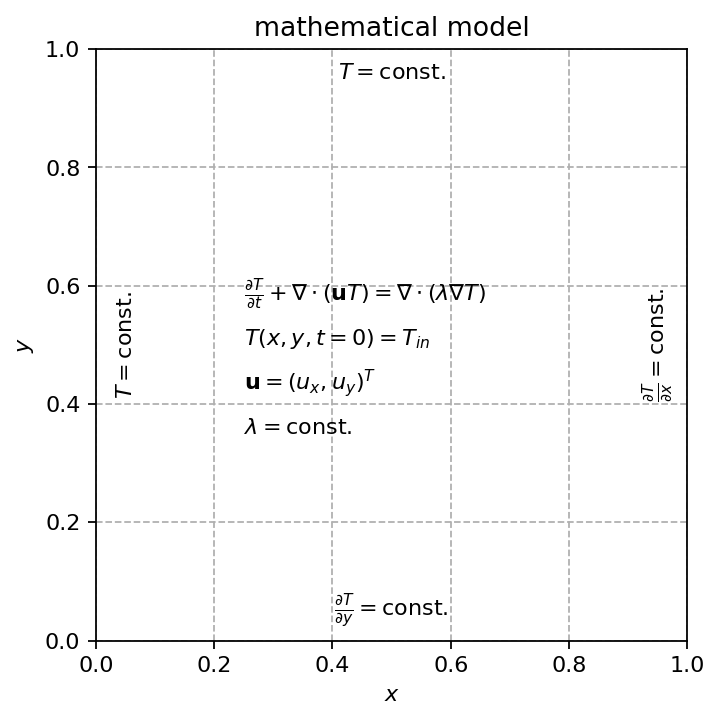

In [63]:
fig, ax = plt.subplots()
ax.set_title("mathematical model")
ax.set_xlabel(r"$x$")
ax.set_ylabel(r"$y$")
ax.text(0.5, 0.95, r"$T=\mathrm{const.}$", ha="center")
ax.text(0.5, 0.05, r"$\frac{\partial T}{\partial y} = \mathrm{const.}$", ha="center", va="center")
ax.text(0.05, 0.5, r"$T= \mathrm{const.}$", ha="center", va="center", rotation=90)
ax.text(0.95, 0.5, r"$\frac{\partial T}{\partial x} = \mathrm{const.}$", ha="center", va="center", rotation=90)
dt_T = r"\frac{\partial T}{\partial t}"
div_T = r"\nabla\cdot\left(\mathbf{u}T\right)"
laplace_T = r"\nabla\cdot\left(\lambda \nabla T\right)"
ax.text(0.25, 0.575, r"${:s} + {:s} = {:s}$".format(dt_T, div_T, laplace_T), ha="left")
ax.text(0.25, 0.5, r"$T(x,y, t=0) = T_{in}$", ha="left")
ax.text(0.25, 0.425, r"$\mathbf{u} = \left(u_x, u_y\right)^T$", ha="left")
ax.text(0.25, 0.35, r"$\lambda = \mathrm{const.}$", ha="left")
ax.set_aspect("equal")
ax.grid(ls="--")
plt.savefig(join(output, "fvm_mathematical_model.svg"), bbox_inches="tight")
plt.show()

### Domain discretization (meshing)

In [64]:
class Mesh(object):
    def __init__(self, L_x, L_y, N_x, N_y, grad_x, grad_y):
        self.L_x = L_x
        self.L_y = L_y
        self.N_x = N_x
        self.N_y = N_y
        self.dx = self._compute_cell_width(L_x, N_x, grad_x)
        self.dy = self._compute_cell_width(L_y, N_y, grad_y)
        self.x = pt.cumsum(self.dx, 0) - self.dx * 0.5
        self.y = pt.cumsum(self.dy, 0) - self.dy * 0.5
        xf = self.x - self.dx * 0.5
        self.xf = pt.cat((xf, pt.tensor([xf[-1]+self.dx[-1]])))
        yf = self.y - self.dy * 0.5
        self.yf = pt.cat((yf, pt.tensor([yf[-1]+self.dy[-1]])))

    def _compute_cell_width(self, L, N, grad):
        if grad == 1.0:
            delta = L / N
            return pt.ones(N) * delta
        else:
            cell_widths = pt.linspace(1.0, grad, N)
            width_0 = L / cell_widths.sum()
            return cell_widths * width_0

    def cell_id(self, i, j) -> int:
        return self.N_x * j + i

    def visualize(self, show_ids=True):
        fig, ax = plt.subplots()
        xx, yy = pt.meshgrid(self.x, self.y, indexing="ij")
        ax.scatter(xx, yy, s=5, c="k", zorder=6)
        for xf_i, yf_i in zip(self.xf, self.yf):
            ax.axvline(xf_i, 0.0, self.L_x, ls="--", c="k", alpha=0.3)
            ax.axhline(yf_i, 0.0, self.L_y, ls="--", c="k", alpha=0.3)
        fontsize = int(10*5/self.N_x)
        if show_ids:
            for i in range(self.N_x):
                for j in range(self.N_y):
                    ax.text(self.x[i], self.y[j]+0.2*self.dy[j], f"({i},{j})",
                            ha="center", va="center", fontsize=fontsize)
                    ax.text(self.x[i], self.y[j]-0.2*self.dy[j], f"{self.cell_id(i, j)}",
                            ha="center", va="center", fontsize=fontsize)
        ax.set_xlim(-0.01, self.L_x+0.01)
        ax.set_ylim(-0.01, self.L_y+0.01)
        ax.set_xlabel(r"$x$")
        ax.set_ylabel(r"$y$")
        ax.set_aspect("equal")
        ax.set(frame_on=False)
        return fig, ax


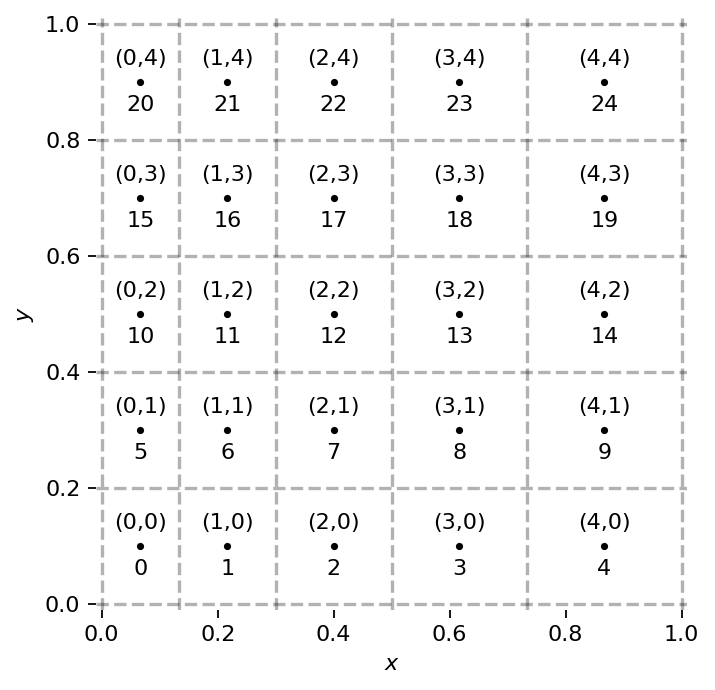

In [65]:
mesh = Mesh(1.0, 1.0, 5, 5, 1.0, 1.0)
assert pt.allclose(mesh.xf, pt.linspace(0.0, 1.0, 6))
assert pt.allclose(mesh.x, pt.linspace(0.1, 0.9, 5))
mesh = Mesh(1.0, 1.0, 5, 5, 2.0, 1.0)
assert pt.isclose(2.0*mesh.dx[0], mesh.dx[-1])
fig, ax = mesh.visualize()
plt.savefig(join(output, "5x5_mesh.svg"), bbox_inches="tight")
plt.show()

### Equation discretization part I - diffusion

In [66]:
class VolScalarField(object):
    def __init__(self, mesh, name, value, bc):
        self.mesh = mesh
        self.name = name
        self.internal_field = pt.ones((mesh.N_x, mesh.N_y))
        self.internal_field *= value
        self.bc = bc

    def visualize(self):
        fig, ax = self.mesh.visualize(False)
        ax.set_title(f"internal field {self.name}")
        pc = ax.pcolormesh(self.mesh.xf, self.mesh.yf, self.internal_field, label=f"{self.name}")
        plt.colorbar(pc, ax=ax)
        return fig, ax

    def __equal__(self, other):
        return self is other

In [67]:
T1 = VolScalarField(mesh, "T", 0.0, None)
T2 = VolScalarField(mesh, "T", 0.0, None)
assert T1 == T1
assert not T1 == T2

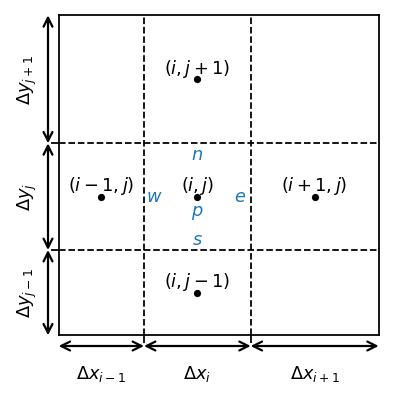

In [68]:
fig = plt.figure(figsize=(2.5, 2.5), frameon=False)
ax = fig.add_axes((0.2, 0.2, 0.8, 0.8))
ax.set_xticks((0.8, 1.8))
ax.set_yticks((0.8, 1.8))
ax.set_xlim(0.0, 3.0)
ax.set_ylim(0.0, 3.0)
ax.set_xticklabels(())
ax.set_yticklabels(())
ax.grid(ls="--", color="k")
xi = (0.4, 1.3, 1.3, 1.3, 2.4)
yi = (1.3, 0.4, 1.3, 2.4, 1.3)
xyi = ("(i-1, j)", "(i, j-1)", "(i, j)", "(i, j+1)", "(i+1, j)")
ax.scatter(xi, yi, c="k", marker="o", s=5)
for xi_i, yi_i, xyi_i in zip(xi, yi, xyi):
    ax.text(xi_i, yi_i, f"${xyi_i}$", fontsize=8, ha="center", va="bottom")
ax.annotate("", (0.0, -0.1), (0.8, -0.1), arrowprops=dict(arrowstyle="<->", shrinkA=0.0, shrinkB=0.0), annotation_clip=False)
ax.annotate("", (0.8, -0.1), (1.8, -0.1), arrowprops=dict(arrowstyle="<->", shrinkA=0.0, shrinkB=0.0), annotation_clip=False)
ax.annotate("", (1.8, -0.1), (3.0, -0.1), arrowprops=dict(arrowstyle="<->", shrinkA=0.0, shrinkB=0.0), annotation_clip=False)
ax.text(0.4, -0.4, r"$\Delta x_{i-1}$", ha="center", fontsize=8)
ax.text(1.3, -0.4, r"$\Delta x_{i}$", ha="center", fontsize=8)
ax.text(2.4, -0.4, r"$\Delta x_{i+1}$", ha="center", fontsize=8)
ax.annotate("", (-0.1, 0.0), (-0.1, 0.8), arrowprops=dict(arrowstyle="<->", shrinkA=0.0, shrinkB=0.0), annotation_clip=False)
ax.annotate("", (-0.1, 0.8), (-0.1, 1.8), arrowprops=dict(arrowstyle="<->", shrinkA=0.0, shrinkB=0.0), annotation_clip=False)
ax.annotate("", (-0.1, 1.8), (-0.1, 3.0), arrowprops=dict(arrowstyle="<->", shrinkA=0.0, shrinkB=0.0), annotation_clip=False)
ax.text(-0.4, 0.4, r"$\Delta y_{j-1}$", va="center", fontsize=8, rotation=90)
ax.text(-0.4, 1.3, r"$\Delta y_{j}$", va="center", fontsize=8, rotation=90)
ax.text(-0.4, 2.4, r"$\Delta y_{j+1}$", va="center", fontsize=8, rotation=90)
ax.text(0.9, 1.3, r"$w$", ha="center", va="center", fontsize=8, color="C0")
ax.text(1.7, 1.3, r"$e$", ha="center", va="center", fontsize=8, color="C0")
ax.text(1.3, 0.9, r"$s$", ha="center", va="center", fontsize=8, color="C0")
ax.text(1.3, 1.7, r"$n$", ha="center", va="center", fontsize=8, color="C0")
ax.text(1.3, 1.15, r"$p$", ha="center", va="center", fontsize=8, color="C0")
plt.savefig(join(output, "stencil_internal.svg"), bbox_inches="tight")
plt.show()

The normal vectors are $\mathbf{n}_n = \left(0, 1\right)^T$, $\mathbf{n}_s = \left(0, -1\right)^T$, $\mathbf{n}_e = \left(1, 0\right)^T$, and $\mathbf{n}_w = \left(-1, 0\right)^T$.

$
\begin{align}
\int\limits_{V} \nabla \cdot \lambda \nabla T \mathrm{d}v &= 
  \int\limits_{x_i-\Delta x_i/2}^{x_i+\Delta x_i/2}\int\limits_{y_j-\Delta y_j/2}^{y_j+\Delta y_j/2} \left[
  \partial_x \lambda \partial_x T + \partial_y \lambda \partial_y T
  \right] \mathrm{d}x\mathrm{d}y\\
  \int\limits_{\partial V} \lambda \nabla T \cdot \mathbf{n}\mathrm{d}o &= \int\limits_{x_i-\Delta x_i/2}^{x_i+\Delta x_i/2} \lambda \left[0\cdot\partial_x T|_n + 0\cdot\partial_x T|_s + 1\cdot\partial_y T|_n - 1\cdot\partial_y T|_s\right]\mathrm{d}x\\
  &+ \int\limits_{y_j-\Delta y_j/2}^{y_j+\Delta y_j/2} \lambda \left[1\cdot\partial_x T|_e - 1\cdot\partial_x T|_w + 0\cdot\partial_y T|_e + 0\cdot\partial_y T|_w\right]\mathrm{d}y\\
  &=\int\limits_{x_i-\Delta x_i/2}^{x_i+\Delta x_i/2} \lambda \left[\partial_y T|_n - \partial_y T|_s\right]\mathrm{d}x +
    \int\limits_{y_j-\Delta y_j/2}^{y_j+\Delta y_j/2} \lambda \left[\partial_x T|_e - \partial_x T|_w\right]\mathrm{d}y
\end{align}
$

Now we have to approximate the derivatives at the cell faces based on the cell-centered values. The most common approach in the FV method assumes a linear profile between the two neighboring cell-centered values. Consequently, the derivative is the constant slope of this linear profile.
$
\begin{align}
  \int\limits_{x_i-\Delta x_i/2}^{x_i+\Delta x_i/2} \lambda \partial_y T|_n \mathrm{d}x &\approx \lambda\Delta x_i
  \frac{T_{i, j+1} - T_{i, j}}{0.5\left(\Delta y_j + \Delta y_{j+1}\right)}\\
  \int\limits_{x_i-\Delta x_i/2}^{x_i+\Delta x_i/2} \lambda \partial_y T|_s \mathrm{d}x &\approx \lambda\Delta x_i
  \frac{T_{i, j} - T_{i, j-1}}{0.5\left(\Delta y_j + \Delta y_{j-1}\right)}\\
  \int\limits_{y_j-\Delta y_j/2}^{y_j+\Delta y_j/2} \lambda \partial_x T|_e \mathrm{d}y &\approx \lambda\Delta y_i
  \frac{T_{i+1, j} - T_{i, j}}{0.5\left(\Delta x_i + \Delta x_{i+1}\right)}\\
  \int\limits_{y_j-\Delta y_j/2}^{y_j+\Delta y_j/2} \lambda \partial_x T|_w \mathrm{d}y &\approx \lambda\Delta y_i
  \frac{T_{i, j} - T_{i-1, j}}{0.5\left(\Delta x_i + \Delta x_{i-1}\right)}
\end{align}
$

$$
\int\limits_{\partial V} \lambda \nabla T \cdot \mathbf{n}\mathrm{d}o \approx
\lambda \Delta x_i \left(
    \frac{T_{i, j+1} - T_{i, j}}{0.5\left(\Delta y_j + \Delta y_{j+1}\right)} - \frac{T_{i, j} - T_{i, j-1}}{0.5\left(\Delta y_j + \Delta y_{j-1}\right)}
\right) +
\lambda \Delta y_j \left(
    \frac{T_{i+1, j} - T_{i, j}}{0.5\left(\Delta x_i + \Delta x_{i+1}\right)} - \frac{T_{i, j} - T_{i-1, j}}{0.5\left(\Delta x_i + \Delta x_{i-1}\right)}
\right)
$$

$
\begin{align}
a_n &= \frac{\lambda \Delta x_i}{0.5\left(\Delta y_j + \Delta y_{j+1}\right)} \\
a_s &= \frac{\lambda \Delta x_i}{0.5\left(\Delta y_j + \Delta y_{j-1}\right)} \\
a_e &= \frac{\lambda \Delta y_j}{0.5\left(\Delta x_i + \Delta x_{i+1}\right)} \\
a_w &= \frac{\lambda \Delta y_j}{0.5\left(\Delta x_i + \Delta x_{i-1}\right)}
\end{align}
$

$$
\int\limits_{\partial V} \lambda \nabla T \cdot \mathbf{n}\mathrm{d}o \approx
a_n T_{i, j+1} - a_n T_{i, j} - a_s T_{i, j} + a_s T_{i, j-1} + a_e T_{i+1, j} - a_e T_{i, j} - a_w T_{i, j} + a_w T_{i-1, j}
$$
 With $a_p = - (a_n + a_s + a_e + a_w)$ we get:
$$
\int\limits_{\partial V} \lambda \nabla T \cdot \mathbf{n}\mathrm{d}o \approx
a_n T_{i, j+1} + a_s T_{i, j-1} + a_e T_{i+1, j} + a_w T_{i-1, j} + a_p T_{i, j}
$$

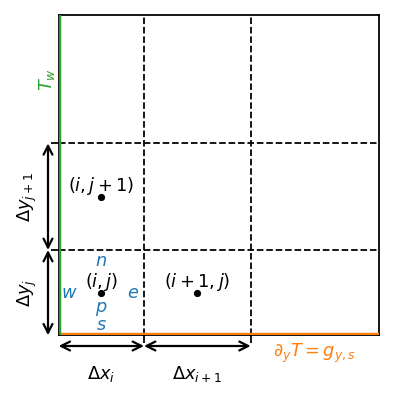

In [69]:
fig = plt.figure(figsize=(2.5, 2.5), frameon=False)
ax = fig.add_axes((0.2, 0.2, 0.8, 0.8))
ax.set_xticks((0.8, 1.8))
ax.set_yticks((0.8, 1.8))
ax.set_xlim(0.0, 3.0)
ax.set_ylim(0.0, 3.0)
ax.set_xticklabels(())
ax.set_yticklabels(())
ax.grid(ls="--", color="k")
xi = (0.4, 0.4, 1.3)
yi = (0.4, 1.3, 0.4)
xyi = ("(i, j)", "(i, j+1)", "(i+1, j)")
ax.scatter(xi, yi, c="k", marker="o", s=5)
for xi_i, yi_i, xyi_i in zip(xi, yi, xyi):
    ax.text(xi_i, yi_i, f"${xyi_i}$", fontsize=8, ha="center", va="bottom")
ax.annotate("", (0.0, -0.1), (0.8, -0.1), arrowprops=dict(arrowstyle="<->", shrinkA=0.0, shrinkB=0.0), annotation_clip=False)
ax.annotate("", (0.8, -0.1), (1.8, -0.1), arrowprops=dict(arrowstyle="<->", shrinkA=0.0, shrinkB=0.0), annotation_clip=False)
ax.text(0.4, -0.4, r"$\Delta x_{i}$", ha="center", fontsize=8)
ax.text(1.3, -0.4, r"$\Delta x_{i+1}$", ha="center", fontsize=8)
ax.annotate("", (-0.1, 0.0), (-0.1, 0.8), arrowprops=dict(arrowstyle="<->", shrinkA=0.0, shrinkB=0.0), annotation_clip=False)
ax.annotate("", (-0.1, 0.8), (-0.1, 1.8), arrowprops=dict(arrowstyle="<->", shrinkA=0.0, shrinkB=0.0), annotation_clip=False)
ax.text(-0.4, 0.4, r"$\Delta y_{j}$", va="center", fontsize=8, rotation=90)
ax.text(-0.4, 1.3, r"$\Delta y_{j+1}$", va="center", fontsize=8, rotation=90)
ax.text(0.1, 0.4, r"$w$", ha="center", va="center", fontsize=8, color="C0")
ax.text(0.7, 0.4, r"$e$", ha="center", va="center", fontsize=8, color="C0")
ax.text(0.4, 0.1, r"$s$", ha="center", va="center", fontsize=8, color="C0")
ax.text(0.4, 0.7, r"$n$", ha="center", va="center", fontsize=8, color="C0")
ax.text(0.4, 0.25, r"$p$", ha="center", va="center", fontsize=8, color="C0")
ax.axhline(0.0, 0.0, 1.0, c="C1", lw=2, zorder=8)
ax.axvline(0.0, 0.0, 1.0, c="C2", lw=2, zorder=8)
ax.text(2.4, -0.2, r"$\partial_y T = g_{y, s}$", ha="center", fontsize=8, c="C1")
ax.text(-0.2, 2.4, r"$T_w$", va="center", fontsize=8, c="C2", rotation=90)
plt.savefig(join(output, "stencil_boundary.svg"), bbox_inches="tight")
plt.show()

$
\begin{align}
  \int\limits_{x_i-\Delta x_i/2}^{x_i+\Delta x_i/2} \lambda \partial_y T|_n \mathrm{d}x &\approx \lambda\Delta x_i
  \frac{T_{i, j+1} - T_{i, j}}{0.5\left(\Delta y_j + \Delta y_{j+1}\right)}\\
  \int\limits_{x_i-\Delta x_i/2}^{x_i+\Delta x_i/2} \lambda \partial_y T|_s \mathrm{d}x &\approx \lambda\Delta x_i
  g_{y,s}\\
  \int\limits_{y_j-\Delta y_j/2}^{y_j+\Delta y_j/2} \lambda \partial_x T|_e \mathrm{d}y &\approx \lambda\Delta y_i
  \frac{T_{i+1, j} - T_{i, j}}{0.5\left(\Delta x_i + \Delta x_{i+1}\right)}\\
  \int\limits_{y_j-\Delta y_j/2}^{y_j+\Delta y_j/2} \lambda \partial_x T|_w \mathrm{d}y &\approx \lambda\Delta y_i
  \frac{T_{i, j} - T_{w}}{0.5\Delta x_i}
\end{align}
$

$$
\int\limits_{\partial V} \lambda \nabla T \cdot \mathbf{n}\mathrm{d}o \approx
\lambda \Delta x_i \left(
    \frac{T_{i, j+1} - T_{i, j}}{0.5\left(\Delta y_j + \Delta y_{j+1}\right)} - g_{y,s}
\right) +
\lambda \Delta y_j \left(
    \frac{T_{i+1, j} - T_{i, j}}{0.5\left(\Delta x_i + \Delta x_{i+1}\right)} - \frac{T_{i, j} - T_w}{0.5\Delta x_i}
\right)
$$

$
\begin{align}
a_n &= \frac{\lambda \Delta x_i}{0.5\left(\Delta y_j + \Delta y_{j+1}\right)} \\
a_s &= 0 \\
a_e &= \frac{\lambda \Delta y_j}{0.5\left(\Delta x_i + \Delta x_{i+1}\right)} \\
a_w &= \frac{\lambda \Delta y_j}{0.5\Delta x_i} \\
b &= -\lambda \Delta x_i g_{y,s} + a_w T_w
\end{align}
$

In [70]:
class FVMatrix(object):
    def __init__(self, matrix, source, field):
        self.matrix = matrix
        self.source = source
        self.field = field

    def __add__(self, other):
        assert self.field == other.field
        return FVMatrix(self.matrix + other.matrix,
                        self.source + other.source,
                        self.field)

    def __sub__(self, other):
        assert self.field == other.field
        return FVMatrix(self.matrix - other.matrix,
                        self.source - other.source,
                        self.field)
    
    def visualize(self, scale=10):
        fig, ax = plt.subplots()
        elements = self.field.mesh.N_x*self.field.mesh.N_y
        ax.set_xticks(range(elements))
        ax.set_yticks(range(elements))
        i, j = self.matrix._indices()
        colors = []
        for c in range(i.shape[0]):
            if self.matrix._values()[c] < 0.0:
                colors.append("C0")
            else:
                colors.append("C1")
        ax.scatter(i, j, s=self.matrix._values().abs()*scale, c=colors, zorder=6)
        colors = []
        for c in range(self.source.shape[0]):
            if self.source[c] < 0.0:
                colors.append("C0")
            else:
                colors.append("C1")
        ax.scatter(pt.ones(elements)*(elements+1), range(elements),  s=self.source.abs()*scale, c=colors, zorder=6)
        ax.axvline(elements, 0, 1, ls="-", c="k")
        ax.tick_params(axis='both', which='major', labelsize=6)
        ax.grid(True, ls="--")
        ax.set_aspect(True)
        ax.set_xlim(-1, elements+2)
        ax.set_ylim(-1, elements)
        ax.invert_yaxis()
        ax.xaxis.set_ticks_position('top')
        return fig, ax

In [71]:
indices = [[3, 6, 9, 12, 15, 18], [12, 15, 18, 21, 24, 24]]
values = [1, 2, 3, -1, -2, -3]
test_matrix = pt.sparse_coo_tensor(indices, values)
test_source = pt.linspace(1, 3, 25)
A1 = FVMatrix(test_matrix, test_source, T1)
A2 = FVMatrix(test_matrix, test_source, T1)
A3 = FVMatrix(test_matrix, test_source, T2)
assert pt.allclose((A1 + A2).matrix.to_dense(), 2*test_matrix.to_dense())
try:
    A1 + A3
except:
    print("Could not add matrices due to field miss-match.")

Could not add matrices due to field miss-match.


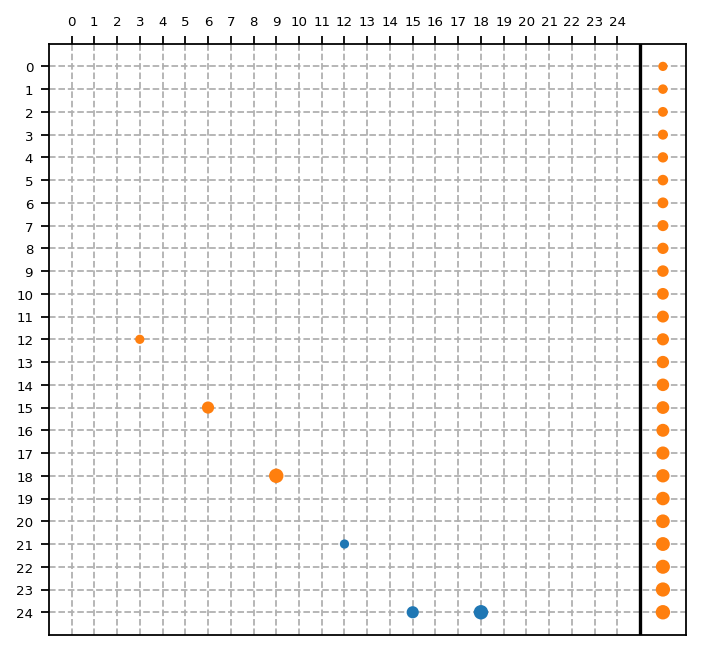

In [72]:
_ = A1.visualize()
plt.show()

In [73]:
def fvm_laplace(diffusivity: float, field: VolScalarField) -> FVMatrix:
    
    row, col, val = [], [], []
    dx, dy = field.mesh.dx, field.mesh.dy
    source = pt.zeros(field.mesh.N_x*field.mesh.N_y)

    def add_east(i, j):
        fac = 2.0*diffusivity*dy[j]
        if i < field.mesh.N_x-1:
            row.append(field.mesh.cell_id(i, j))
            col.append(field.mesh.cell_id(i+1, j))
            a_e, b_e = fac / (dx[i+1]+dx[i]), 0.0
            val.append(a_e)
        else: # east face is boundary
            type_e, val_e = field.bc["right"]
            if type_e == "fixedValue":
                a_e, b_e = fac / dx[i], -fac / dx[i] * val_e
            else:
                a_e, b_e = 0.0, -diffusivity * dy[j] * val_e
        return a_e, b_e

    def add_west(i, j):
        fac = 2.0*diffusivity*dy[j]
        if i > 0:
            row.append(field.mesh.cell_id(i, j))
            col.append(field.mesh.cell_id(i-1, j))
            a_w, b_w = fac / (dx[i]+dx[i-1]), 0.0
            val.append(a_w)
        else: # west face is boundary
            type_w, val_w = field.bc["left"]
            if type_w == "fixedValue":
                a_w, b_w = fac / dx[i], -fac / dx[i] * val_w
            else:
                a_w, b_w = 0.0, diffusivity * dy[j] * val_w
        return a_w, b_w

    def add_north(i, j):
        fac = 2.0*diffusivity*dx[i]
        if j < field.mesh.N_y-1:
            row.append(field.mesh.cell_id(i, j))
            col.append(field.mesh.cell_id(i, j+1))
            a_n, b_n = fac / (dy[j+1]+dy[j]), 0.0
            val.append(a_n)
        else: # north face is boundary
            type_n, val_n = field.bc["top"]
            if type_n == "fixedValue":
                a_n, b_n = fac / dy[j], -fac / dy[j] * val_n
            else:
                a_n, b_n = 0.0, -diffusivity * dx[i] * val_n
        return a_n, b_n

    def add_south(i, j):
        fac = 2.0*diffusivity*dx[i]
        if j > 0:
            row.append(field.mesh.cell_id(i, j))
            col.append(field.mesh.cell_id(i, j-1))
            a_s, b_s = fac / (dy[j]+dy[j-1]), 0.0
            val.append(a_s)
        else: # south face is boundary
            type_s, val_s = field.bc["bottom"]
            if type_s == "fixedValue":
                a_s, b_s = fac / dy[j], -fac / dy[j] * val_s
            else:
                a_s, b_s = 0.0, diffusivity * dx[i] * val_s
        return a_s, b_s

    def add_center(i, j, coeffs):
        row.append(field.mesh.cell_id(i, j))
        col.append(field.mesh.cell_id(i, j))
        val.append(-sum(coeffs))

    def add_source(i, j, sources):
        internal = 0 < i < field.mesh.N_x-1 and 0 < j < field.mesh.N_y-1
        if not internal:
            source[field.mesh.cell_id(i, j)] = sum(sources)

    for i in range(field.mesh.N_x):
        for j in range(field.mesh.N_y):
            a_e, b_e = add_east(i, j)
            a_w, b_w = add_west(i, j)
            a_n, b_n = add_north(i, j)
            a_s, b_s = add_south(i, j)
            add_center(i, j, (a_e, a_w, a_n, a_s))
            add_source(i, j, (b_e, b_w, b_n, b_s))
        
    return FVMatrix(pt.sparse_coo_tensor([row, col], val),
                    source, field)


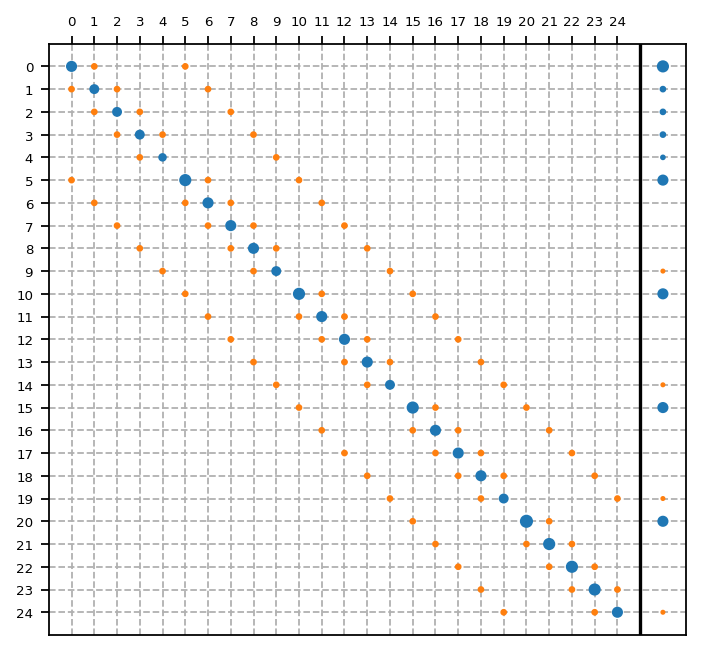

In [74]:
mesh = Mesh(1.0, 1.0, 5, 5, 1.0, 1.0)
bc = {
    "left" : ("fixedValue", 2.0),
    "right" : ("fixedGradient", -2.0),
    "top" : ("fixedValue", 0.0),
    "bottom" : ("fixedGradient", -5.0),
}
T = VolScalarField(mesh, "T", 0.0, bc)
matrix = fvm_laplace(1.0, T)
fig, ax = matrix.visualize(scale=4)
plt.savefig(join(output, "diff_fv_matrix.svg"), bbox_inches="tight")
plt.show()

### Iterative solution

#### Jacobi and Gauss-Seidel methods

In [75]:
x, y = 0, 0
x_true, y_true = -8, 3
TOL = 1e-3
res_jacobi = []
for i in range(50):
    x_new = (2 + 2*y) / (-1)
    y_new = (-5 + 2*x) / (-7)
    x, y = x_new, y_new
    res_jacobi.append(abs(x-x_true) + abs(y-y_true))
    if res_jacobi[-1] < TOL:
        print(f"Converged after {i+1} iterations.")
        break

Converged after 34 iterations.


In [76]:
x, y = 0, 0
res_gauss_seidel = []
for i in range(50):
    x = (2 + 2*y) / (-1)
    y = (-5 + 2*x) / (-7)
    res_gauss_seidel.append(abs(x-x_true) + abs(y-y_true))
    if res_gauss_seidel[-1] < TOL:
        print(f"Converged after {i+1} iterations.")
        break

Converged after 17 iterations.


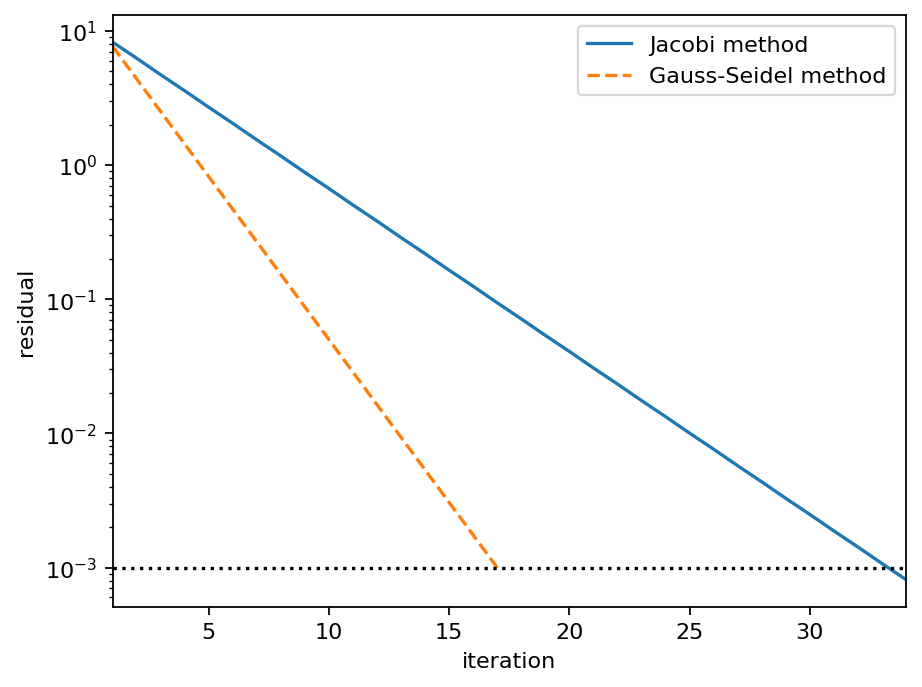

In [77]:
plt.plot(range(1, len(res_jacobi)+1), res_jacobi, ls="-", label="Jacobi method")
plt.plot(range(1, len(res_gauss_seidel)+1), res_gauss_seidel, ls="--", label="Gauss-Seidel method")
plt.hlines(TOL, 1, len(res_jacobi), colors="k", ls=":")
plt.xlabel("iteration")
plt.ylabel("residual")
plt.xlim(1, len(res_jacobi))
plt.yscale("log")
plt.legend()
plt.savefig(join(output, "jacobi_vs_gauss_seidel.svg"), bbox_inches="tight")
plt.show()

#### Sparse versus dense matrices

In [78]:
def compute_n_elements_dense(Nx: int, Ny: int) -> int:
    return (Nx*Ny)**2

def compute_n_elements_sparse(Nx: int, Ny: int) -> int:
    four_nb = (Nx-2) * (Ny-2)
    three_nb = 2*(Nx-2) + 2*(Ny-2)
    two_nb = 4
    return (four_nb*5 + three_nb*4 + two_nb*3) * 3

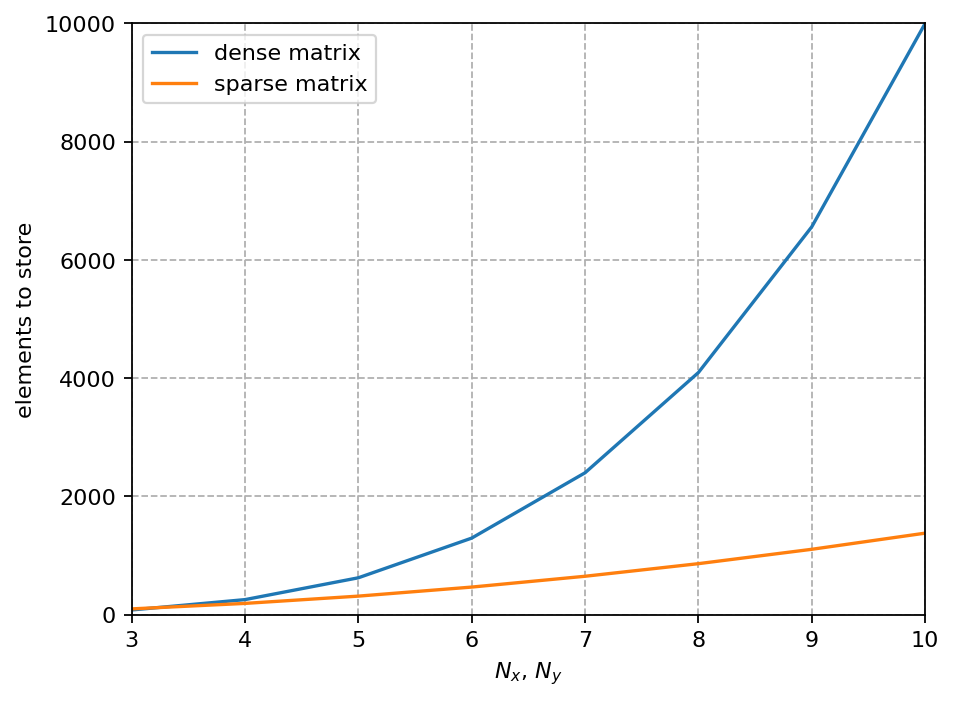

In [79]:
N_cells = range(3, 11)
N_float_dense = [compute_n_elements_dense(n, n) for n in N_cells]
N_float_sparse = [compute_n_elements_sparse(n, n) for n in N_cells]

plt.plot(N_cells, N_float_dense, label="dense matrix")
plt.plot(N_cells, N_float_sparse, label="sparse matrix")
plt.xlabel(r"$N_x$, $N_y$")
plt.ylabel("elements to store")
plt.legend()
plt.xlim(3, 10)
plt.ylim(0, 1e4)
plt.grid(ls="--")
plt.savefig(join(output, "dense_vs_sparse.svg"), bbox_inches="tight")
plt.show()

In [80]:
def gauss_seidel(A, b, x, tol=1.0e-6, max_iter=1000):
    res_iter = []
    for it in range(max_iter):
        for i in range(x.shape[0]):
            row_sum = 0.0
            for row, col in zip(*A._indices()):
                if row == i and col != i:
                    row_sum += (A[row, col] * x[col]).item()
            x[i] = (b[i] - row_sum) / A[i, i]
        res_iter.append(pt.linalg.norm(b - A.mv(x)).item())
        if res_iter[-1] < tol:
            print(f"Linear solver converged in {it+1} iterations.")
            print("Final residual: {:2.2e}".format(res_iter[-1]))
            return x, res_iter
    print(f"Linear solver did not converge after {it+1} iterations.")
    print("Final residual: {:2.2e}".format(res_iter[-1]))
    return x, res_iter


In [81]:
mesh = Mesh(1.0, 1.0, 5, 5, 1.0, 1.0)
bc = {
    "left" : ("fixedValue", 2.0),
    "right" : ("fixedGradient", -2.0),
    "top" : ("fixedValue", 0.0),
    "bottom" : ("fixedGradient", -5.0),
}
T = VolScalarField(mesh, "T", 0.0, bc)
matrix = fvm_laplace(0.1, T)

Tsol, res_coarse = gauss_seidel(matrix.matrix, matrix.source, matrix.field.internal_field.flatten(), tol=1.0e-2)
T = VolScalarField(mesh, "T", Tsol.reshape(5, 5), bc)

Linear solver converged in 23 iterations.
Final residual: 9.02e-03


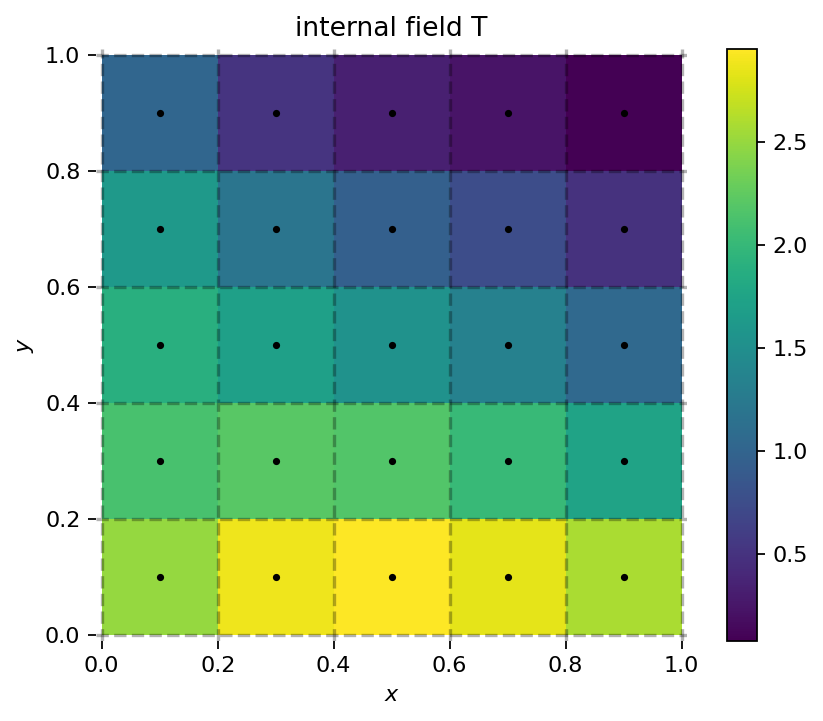

In [82]:
fig, ax = T.visualize()
plt.savefig(join(output, "5x5_solution.svg"), bbox_inches="tight")
plt.show()

In [83]:
mesh = Mesh(1.0, 1.0, 10, 10, 1.0, 1.0)
bc = {
    "left" : ("fixedValue", 2.0),
    "right" : ("fixedGradient", -2.0),
    "top" : ("fixedValue", 0.0),
    "bottom" : ("fixedGradient", -5.0),
}
T = VolScalarField(mesh, "T", 0.0, bc)
matrix = fvm_laplace(0.1, T)

Tsol, res_fine = gauss_seidel(matrix.matrix, matrix.source, matrix.field.internal_field.flatten(), tol=1.0e-2)
T = VolScalarField(mesh, "T", Tsol.reshape(10, 10), bc)

Linear solver converged in 74 iterations.
Final residual: 9.89e-03


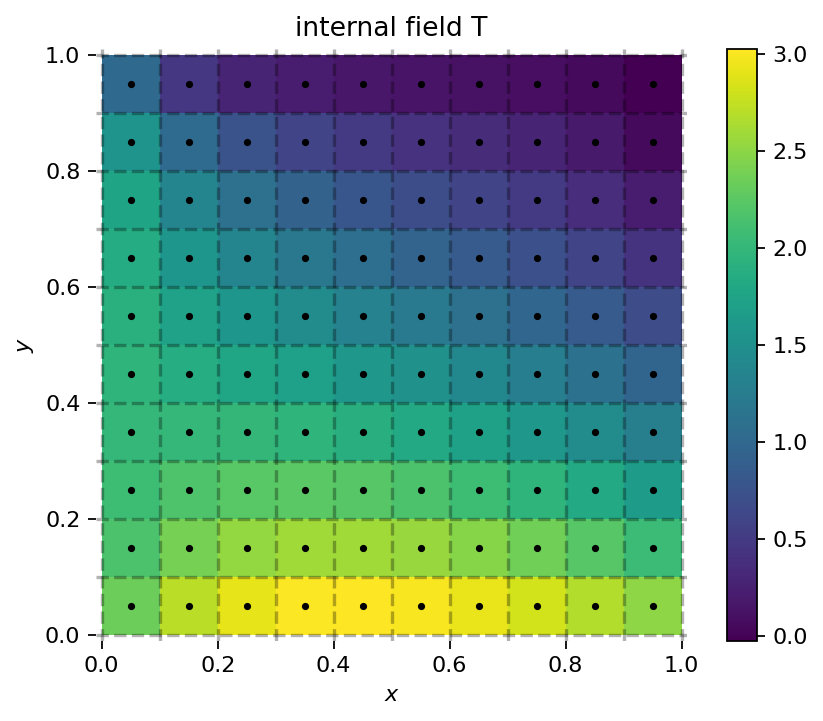

In [84]:
fig, ax = T.visualize()
plt.savefig(join(output, "10x10_solution.svg"), bbox_inches="tight")
plt.show()

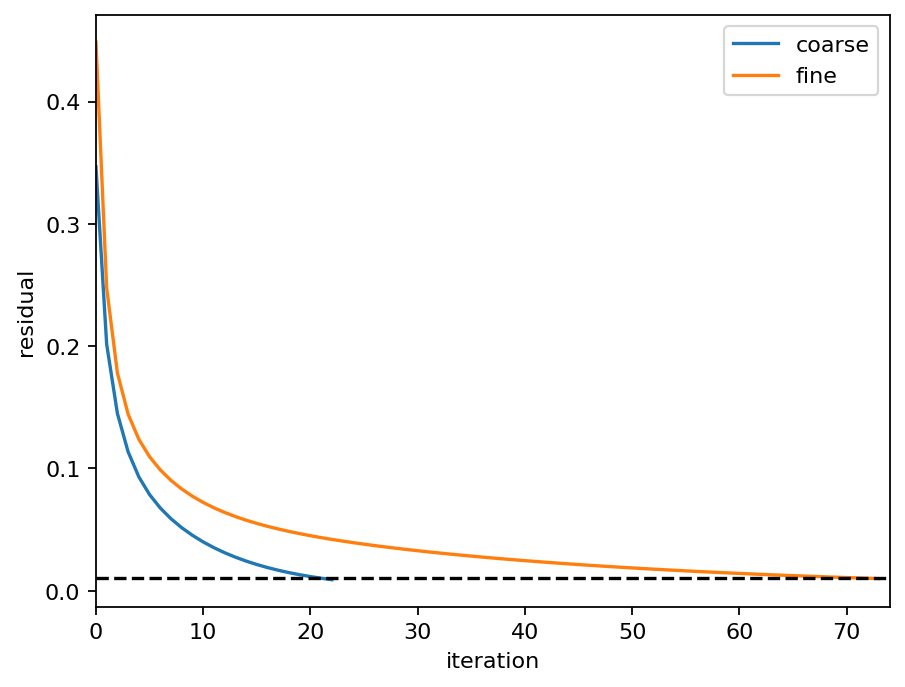

In [85]:
plt.plot(range(len(res_coarse)), res_coarse, label="coarse")
plt.plot(range(len(res_fine)), res_fine, label="fine")
plt.gca().axhline(1e-2, 0, 1, ls="--", c="k")
plt.xlabel("iteration")
plt.ylabel("residual")
plt.xlim(0, max(len(res_coarse), len(res_fine)))
plt.legend()
plt.savefig(join(output, "res_coarse_fine.svg"), bbox_inches="tight")
plt.show()

### Equation discretization part II - convection

The velocity vector is defined as $\mathbf{u} = \left(u_x, u_y \right)^T$.
$
\begin{align}
\int\limits_{V} \nabla \cdot \mathbf{u}T \mathrm{d}v &= 
  \int\limits_{x_i-\Delta x_i/2}^{x_i+\Delta x_i/2}\int\limits_{y_j-\Delta y_j/2}^{y_j+\Delta y_j/2} \left[
  \partial_x u_x T + \partial_y u_x T
  \right] \mathrm{d}x\mathrm{d}y\\
  \int\limits_{\partial V} \mathbf{u} T \cdot \mathbf{n}\mathrm{d}o &= \int\limits_{x_i-\Delta x_i/2}^{x_i+\Delta x_i/2} \left[0\cdot u_xT|_n + 0\cdot u_xT|_s + 1\cdot u_yT|_n - 1\cdot u_y T|_s\right]\mathrm{d}x\\
  &+ \int\limits_{y_j-\Delta y_j/2}^{y_j+\Delta y_j/2} \left[1\cdot u_x T|_e - 1\cdot u_x T|_w + 0\cdot u_y T|_e + 0\cdot u_y T|_w\right]\mathrm{d}y\\
  &=\int\limits_{x_i-\Delta x_i/2}^{x_i+\Delta x_i/2} \left[u_y T|_n - u_y T|_s\right]\mathrm{d}x +
    \int\limits_{y_j-\Delta y_j/2}^{y_j+\Delta y_j/2} \left[u_x T|_e - u_x T|_w\right]\mathrm{d}y
\end{align}
$

Now we have to approximate the value of $T$ at the cell faces based on the cell-centered values. A typical choice for convection-diffusion-equations is linear interpolation. As the diffusion terms becomes smaller, we may have to resort to interpolation schemes that account for the sign of the velocity on the face.
$
\begin{align}
  \int\limits_{x_i-\Delta x_i/2}^{x_i+\Delta x_i/2} u_y T|_n \mathrm{d}x &\approx u_{y,j+1} \Delta x_i
  \left( T_{i,j} + \frac{\Delta y_j}{\Delta y_j + \Delta y_{j+1}} \left(T_{i,j+1} - T_{i,j} \right)\right)\\
  \int\limits_{x_i-\Delta x_i/2}^{x_i+\Delta x_i/2} u_y T|_s \mathrm{d}x &\approx u_{y,j}\Delta x_i
  \left( T_{i,j} + \frac{\Delta y_j}{\Delta y_j + \Delta y_{j-1}} \left( T_{i,j-1} - T_{i,j} \right)\right)\\
  \int\limits_{y_j-\Delta y_j/2}^{y_j+\Delta y_j/2} u_x T|_e \mathrm{d}y &\approx u_{x,i+1}\Delta y_j
  \left( T_{i,j} + \frac{\Delta x_i}{\Delta x_i + \Delta x_{i+1}} \left( T_{i+1,j} - T_{i,j} \right) \right)\\
  \int\limits_{y_j-\Delta y_j/2}^{y_j+\Delta y_j/2} u_x T|_w \mathrm{d}y &\approx u_{x,i}\Delta y_j
  \left( T_{i,j} + \frac{\Delta x_i}{\Delta x_i + \Delta x_{i-1}} \left( T_{i-1,j} - T_{i,j} \right) \right)
\end{align}
$

$
\begin{align}
\varphi_n &= u_{y,j+1}\Delta x_i,\quad &a_n &= \frac{\Delta y_j}{\Delta y_j + \Delta y_{j+1}} \\
\varphi_s &= u_{y,j}\Delta x_i,\quad &a_s &= \frac{\Delta y_j}{\Delta y_j + \Delta y_{j-1}} \\
\varphi_e &= u_{x,i+1}\Delta y_j,\quad &a_e& = \frac{\Delta x_i}{\Delta x_i + \Delta x_{i+1}} \\
\varphi_w &= u_{x,i}\Delta y_j,\quad &a_w& = \frac{\Delta x_i}{\Delta x_i + \Delta x_{i-1}}
\end{align}
$

$
\begin{align}
  \int\limits_{\partial V} \mathbf{u} T \cdot \mathbf{n}\mathrm{d}o &=
   \varphi_n \left[ T_{i,j} + a_n \left( T_{i,j+1}-T_{i,j} \right) \right]
  -\varphi_s \left[ T_{i,j} + a_s \left( T_{i,j-1}-T_{i,j} \right) \right]
  +\varphi_e \left[ T_{i,j} + a_e \left( T_{i+1,j}-T_{i,j} \right) \right]
  -\varphi_w \left[ T_{i,j} + a_w \left( T_{i-1,j}-T_{i,j} \right) \right]\\
  &= \varphi_n a_n T_{i,j+1} - \varphi_s a_s T_{i,j-1} + \varphi_e a_e T_{i+1,j} - \varphi_w a_w T_{i-1,j} + a_p T_{i,j}
\end{align}
$

with
$$
a_p = \varphi_n (1-a_n) - \varphi_s (1-a_s) + \varphi_e (1-a_e) - \varphi_w (1-a_w)
$$

In [86]:
def stream_function(x, y, A):
    return 2*A*x*y

def velocity_field(x, y, A):
    u_x = 2*A*x
    u_y = -2*A*y
    return u_x, u_y

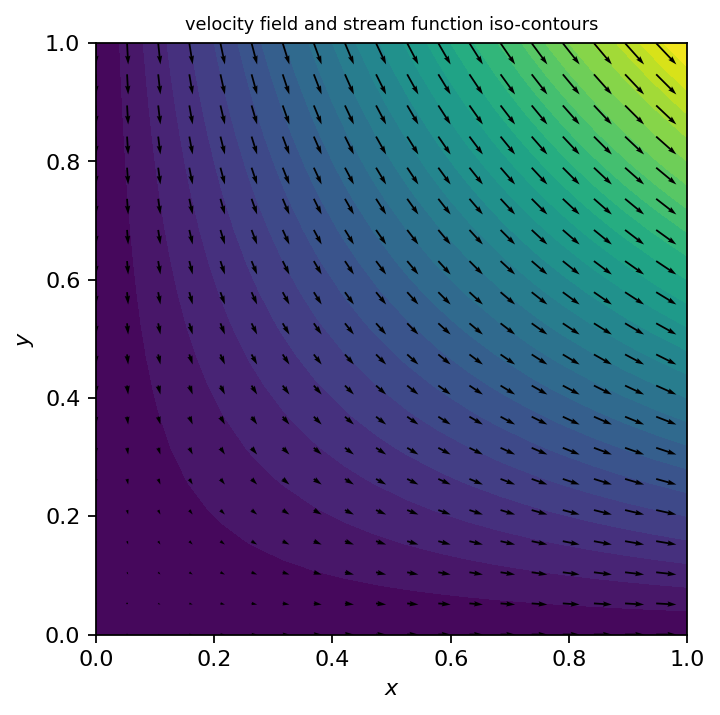

In [87]:
fig, ax = plt.subplots()

A = 1
N = 20
x = pt.linspace(0, 1, N)
y = pt.linspace(0, 1, N)
xx, yy = pt.meshgrid(x, y, indexing="ij")
psi = stream_function(xx, yy, A)
u_x, u_y = velocity_field(xx, yy, A)
ax.contourf(xx, yy, psi, levels=30)
ax.quiver(xx, yy, u_x, u_y, zorder=6)
ax.set_xlabel(r"$x$")
ax.set_ylabel(r"$y$")
ax.set_aspect("equal")
ax.set_title("velocity field and stream function iso-contours", fontsize=8)
plt.savefig(f"{output}/2D_velocity_field.svg", bbox_inches="tight")

In [88]:
class SurfaceVectorField(object):
    def __init__(self, mesh, name, value_x, value_y):
        self.mesh = mesh
        self.name = name
        self.surface_field_x = pt.ones((mesh.N_x + 1, mesh.N_y)) * value_x
        self.surface_field_y = pt.ones((mesh.N_x, mesh.N_y + 1)) * value_y

    def x(self):
        return self.surface_field_x

    def y(self):
        return self.surface_field_y

    def visualize(self, scale):
        fig, ax = self.mesh.visualize(False)
        ax.set_title(f"internal field {self.name}")
        xx, yy = pt.meshgrid(mesh.x, mesh.y, indexing="ij")
        ax.quiver(xx, yy, 0.5*(self.x()[:-1, :] + self.x()[1:, :]), 0.5*(self.y()[:, :-1] + self.y()[:, 1:]), zorder=6, scale=1.0/scale)
        xx, yy = pt.meshgrid(mesh.xf, mesh.y, indexing="ij")
        ax.quiver(xx, yy, self.x(), pt.zeros_like(self.x()), zorder=6, alpha=0.3, scale=1.0/scale)
        xx, yy = pt.meshgrid(mesh.x, mesh.yf, indexing="ij")
        ax.quiver(xx, yy, pt.zeros_like(self.y()), self.y(), zorder=6, alpha=0.3, scale=1.0/scale)
        return fig, ax

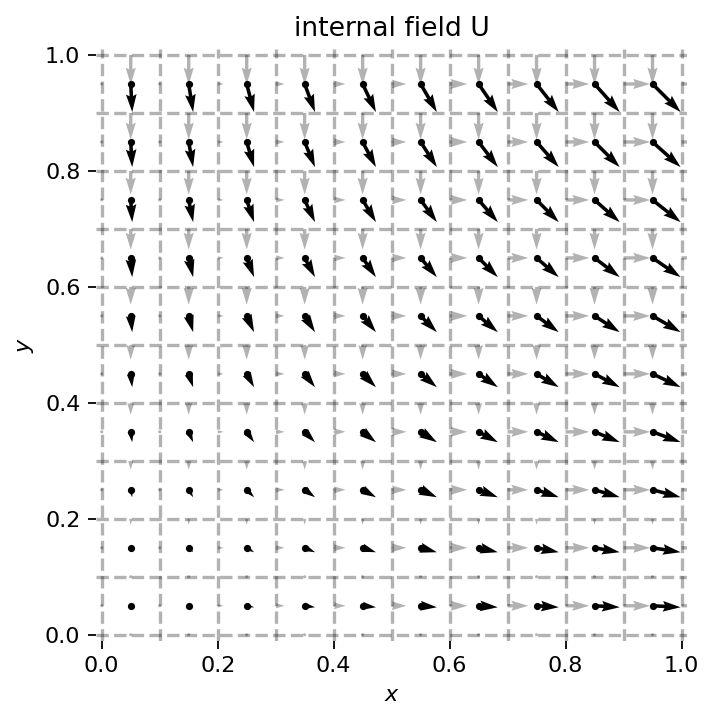

In [98]:
def create_surface_velocity_field(mesh: Mesh, A: float) -> SurfaceVectorField:
    xx, yy = pt.meshgrid(mesh.xf, mesh.y, indexing="ij")
    u_x, _ = velocity_field(xx, yy, A)
    xx, yy = pt.meshgrid(mesh.x, mesh.yf, indexing="ij")
    _, u_y = velocity_field(xx, yy, A)
    return SurfaceVectorField(mesh, "U", u_x, u_y)

mesh = Mesh(1.0, 1.0, 10, 10, 1.0, 1.0)
fig, ax = create_surface_velocity_field(mesh, 0.05).visualize(scale=0.5)
plt.savefig(join(output, "surface_velocity_corner_flow.svg"), bbox_inches="tight")
plt.show()

In [90]:
def fvm_div(vel: SurfaceVectorField, field: VolScalarField) -> FVMatrix:
    
    row, col, val = [], [], []
    dx, dy = field.mesh.dx, field.mesh.dy
    source = pt.zeros(field.mesh.N_x*field.mesh.N_y)

    def add_east(i, j):
        phi_e = vel.x()[i+1, j] * dy[j]
        if i < field.mesh.N_x-1:
            row.append(field.mesh.cell_id(i, j))
            col.append(field.mesh.cell_id(i+1, j))
            a_e, b_e = dx[i] / (dx[i+1]+dx[i]), 0.0
            val.append(phi_e*a_e)
        else: # east face is boundary
            type_e, val_e = field.bc["right"]
            if type_e == "fixedValue":
                a_e, b_e = 1.0, -phi_e*val_e
            else:
                a_e, b_e = 0.0, -phi_e*dx[i]*val_e*0.5
        return a_e, b_e, phi_e

    def add_west(i, j):
        phi_w = vel.x()[i, j] * dy[j]
        if i > 0:
            row.append(field.mesh.cell_id(i, j))
            col.append(field.mesh.cell_id(i-1, j))
            a_w, b_w = dx[i] / (dx[i-1]+dx[i]), 0.0
            val.append(-phi_w*a_w)
        else: # west face is boundary
            type_w, val_w = field.bc["left"]
            if type_w == "fixedValue":
                a_w, b_w = 1.0, phi_w*val_w
            else:
                a_w, b_w = 0.0, -phi_w*dx[i]*val_w*0.5
        return a_w, b_w, phi_w

    def add_north(i, j):
        phi_n = vel.y()[i, j+1] * dx[i]
        if j < field.mesh.N_y-1:
            row.append(field.mesh.cell_id(i, j))
            col.append(field.mesh.cell_id(i, j+1))
            a_n, b_n = dy[j] / (dy[j+1]+dy[j]), 0.0
            val.append(phi_n*a_n)
        else: # north face is boundary
            type_n, val_n = field.bc["top"]
            if type_n == "fixedValue":
                a_n, b_n = 1.0, -phi_n*val_n
            else:
                a_n, b_n = 0.0, -phi_n*dy[j]*val_n*0.5
        return a_n, b_n, phi_n

    def add_south(i, j):
        phi_s = vel.y()[i, j] * dx[i]
        if j > 0:
            row.append(field.mesh.cell_id(i, j))
            col.append(field.mesh.cell_id(i, j-1))
            a_s, b_s = dy[j] / (dy[j]+dy[j-1]), 0.0
            val.append(-phi_s*a_s)
        else: # south face is boundary
            type_s, val_s = field.bc["bottom"]
            if type_s == "fixedValue":
                a_s, b_s = 1.0, phi_s*val_s
            else:
                a_s, b_s = 0.0, -phi_s*dy[j]*val_s*0.5
        return a_s, b_s, phi_s

    def add_center(i, j, coeffs):
        row.append(field.mesh.cell_id(i, j))
        col.append(field.mesh.cell_id(i, j))
        val.append(sum(coeffs))

    def add_source(i, j, sources):
        internal = 0 < i < field.mesh.N_x-1 and 0 < j < field.mesh.N_y-1
        if not internal:
            source[field.mesh.cell_id(i, j)] = sum(sources)

    for i in range(field.mesh.N_x):
        for j in range(field.mesh.N_y):
            a_e, b_e, phi_e = add_east(i, j)
            a_w, b_w, phi_w = add_west(i, j)
            a_n, b_n, phi_n = add_north(i, j)
            a_s, b_s, phi_s = add_south(i, j)
            add_center(i, j, (phi_e*(1.0-a_e), -phi_w*(1.0-a_w), phi_n*(1.0-a_n), -phi_s*(1.0-a_s)))
            add_source(i, j, (b_e, b_w, b_n, b_s))
        
    return FVMatrix(pt.sparse_coo_tensor([row, col], val),
                    source, field)

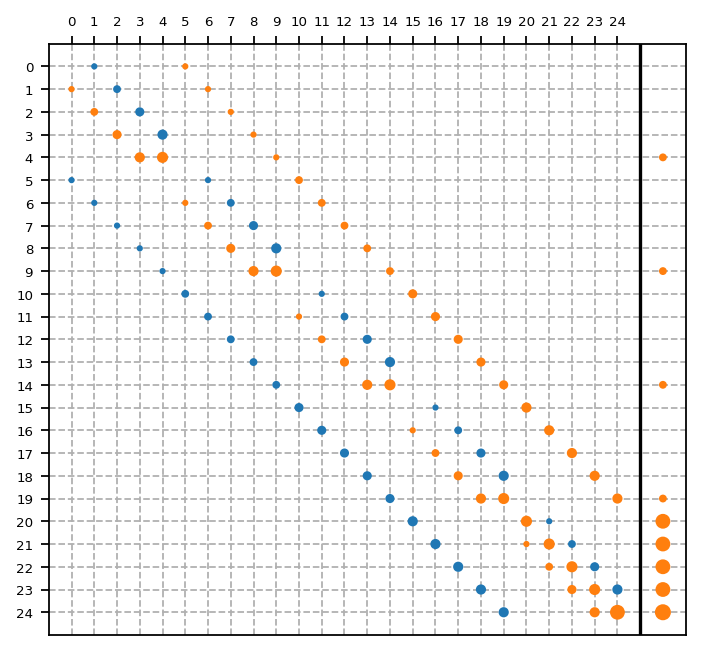

In [91]:
mesh = Mesh(1.0, 1.0, 5, 5, 1.0, 1.0)
vel = create_surface_velocity_field(mesh, 1.0)
bc = {
    "left" : ("fixedValue", 2.0),
    "right" : ("fixedGradient", -2.0),
    "top" : ("fixedValue", 1.0),
    "bottom" : ("fixedGradient", -5.0),
}
T = VolScalarField(mesh, "T", 0.0, bc)
matrix = fvm_div(vel, T)
fig, ax = matrix.visualize(scale=80)
plt.savefig(join(output, "conv_fv_matrix.svg"), bbox_inches="tight")
plt.show()

In [92]:
mesh = Mesh(1.0, 1.0, 5, 5, 1.0, 1.0)
vel = create_surface_velocity_field(mesh, 0.05)
bc = {
    "left" : ("fixedValue", 2.0),
    "right" : ("fixedGradient", -2.0),
    "top" : ("fixedValue", 0.0),
    "bottom" : ("fixedGradient", -5.0),
}
T = VolScalarField(mesh, "T", 0.0, bc)
pde = fvm_div(vel, T) - fvm_laplace(0.1, T)

Tsol, res_coarse = gauss_seidel(pde.matrix, pde.source, pde.field.internal_field.flatten(), tol=1.0e-2)
T = VolScalarField(mesh, "T", Tsol.reshape(5, 5), bc)

Linear solver converged in 20 iterations.
Final residual: 9.34e-03


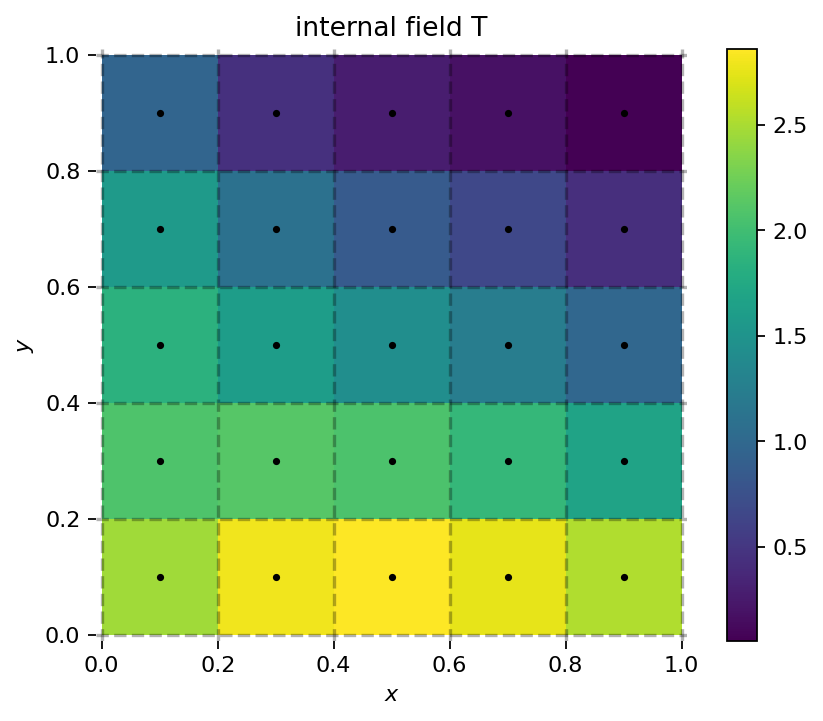

In [93]:
fig, ax = T.visualize()
plt.savefig(join(output, "5x5_full_solution.svg"), bbox_inches="tight")
plt.show()

In [94]:
mesh = Mesh(1.0, 1.0, 10, 10, 1.0, 1.0)
vel = create_surface_velocity_field(mesh, 0.05)
bc = {
    "left" : ("fixedValue", 2.0),
    "right" : ("fixedGradient", -2.0),
    "top" : ("fixedValue", 0.0),
    "bottom" : ("fixedGradient", -5.0),
}
T = VolScalarField(mesh, "T", 0.0, bc)
pde = fvm_div(vel, T) - fvm_laplace(0.1, T)

Tsol, res_coarse = gauss_seidel(pde.matrix, pde.source, pde.field.internal_field.flatten(), tol=1.0e-2)
T = VolScalarField(mesh, "T", Tsol.reshape(10, 10), bc)

Linear solver converged in 66 iterations.
Final residual: 9.97e-03


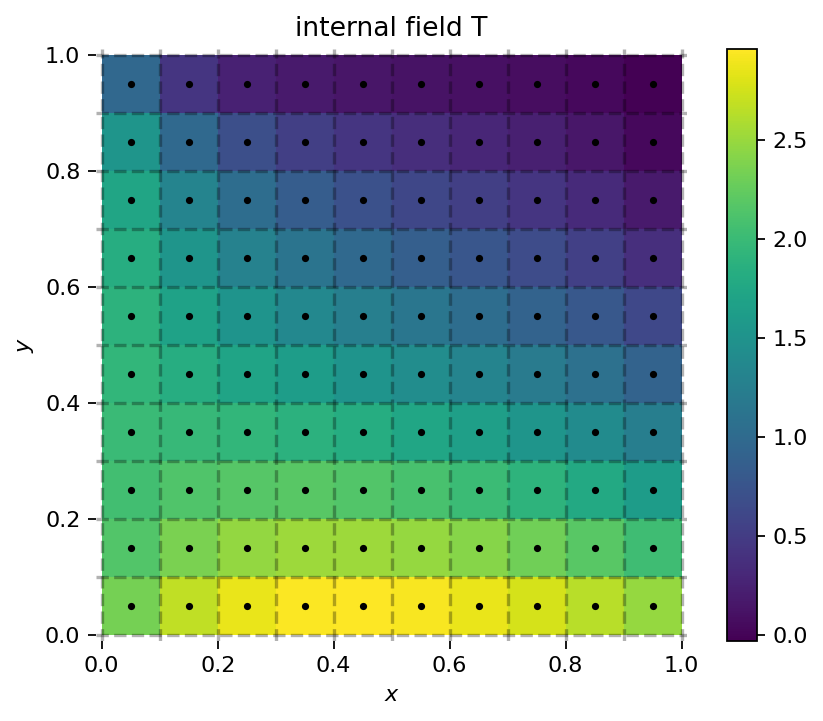

In [95]:
fig, ax = T.visualize()
plt.savefig(join(output, "10x10_full_solution.svg"), bbox_inches="tight")
plt.show()

In [96]:
mesh = Mesh(1.0, 1.0, 10, 10, 1.0, 1.0)
vel = create_surface_velocity_field(mesh, 0.05)
bc = {
    "left" : ("fixedValue", 2.0),
    "right" : ("fixedGradient", -2.0),
    "top" : ("fixedValue", 1.0),
    "bottom" : ("fixedGradient", -5.0),
}
T = VolScalarField(mesh, "T", 0.0, bc)
pde = fvm_div(vel, T) - fvm_laplace(0.1, T)

Tsol, res_coarse = gauss_seidel(pde.matrix, pde.source, pde.field.internal_field.flatten(), tol=1.0e-6)
T = VolScalarField(mesh, "T", Tsol.reshape(10, 10), bc)

Linear solver converged in 358 iterations.
Final residual: 9.53e-07


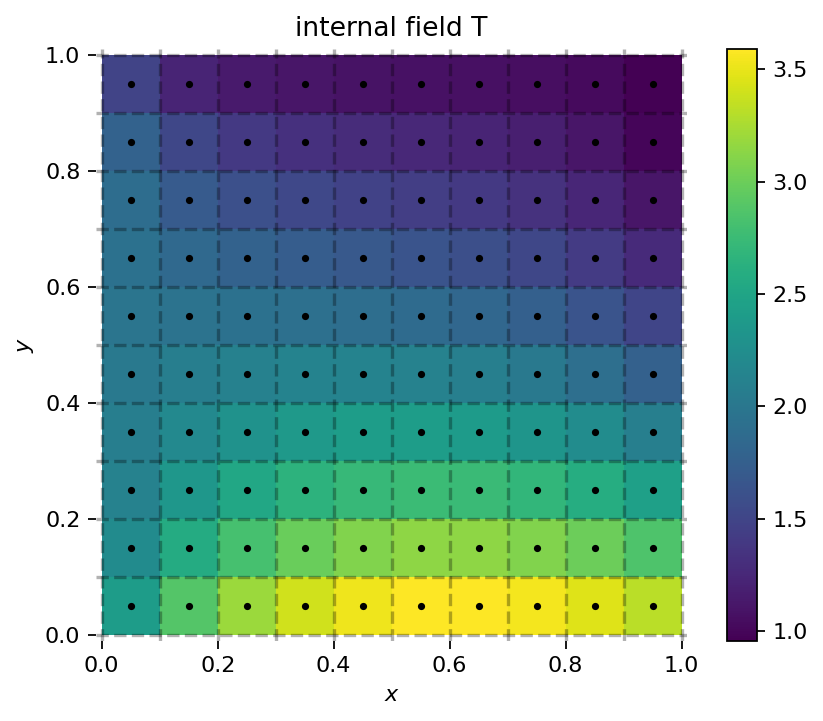

In [97]:
fig, ax = T.visualize()
plt.savefig(join(output, "10x10_full_solution_with_inlet.svg"), bbox_inches="tight")
plt.show()

## FVM in OpenFOAM

Running the same simulation as above in OpenFOAM:

```
# starting from the repository's top level
# define environment variables
source setup-env
# create a copy, navigate to the copy, and run the simulation
cp -r test_cases/corner_flow exercises/
cd exercises/corner_flow/
./Allrun
# post-processing in ParaView
paraview post.foam
```

## FVM in Basilisk